In [9]:
import os 
import cv2
import sys
import json
sys.path.append('..')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from vehicle_nowcasting.datasets import dataset, utils, generate_anchors

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/labelmap.json', 'r'))

In [3]:
sources = dataset.build_source_from_metadata(metadata,
                                             label_map, 
                                             data_dir)

In [8]:
vehicle = dataset.make_dataset(sources, batch_size=3)

W0904 00:43:11.433200 140631945004864 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


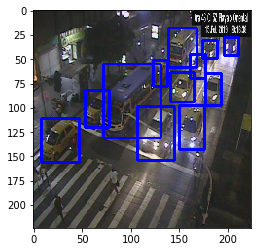

In [5]:
tensor = next(iter(vehicle))
img = utils.plot_bb(tensor[0].numpy(), tensor[1].numpy(), (0, 0, 255), 2)
plt.imshow(img)

In [38]:
from itertools import product

delta = 10 * np.array(list(product(range(30),range(30))))
delta = np.hstack([delta, delta])
anchors = generate_anchors.generate_anchors(base_size=4,
                           ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                           scales=2 ** np.arange(3, 10))

anchors = anchors.reshape(-1, 4, 1) + np.zeros((*anchors.shape, delta.shape[0]))
anchors += delta.T.reshape(1, 4, -1)
anchors = anchors.transpose(2, 0, 1).reshape(-1, 4)
anchors = anchors[((anchors > 0) & (anchors < 480)).all(axis=-1), :]

In [39]:
#paddings = tf.constant([[0, 0], [1, 0]])
anchors = tf.constant(anchors, dtype=tf.int32)

In [48]:
iou_matrix = utils.iou(anchors, tensor[1][:, 1:])
#pos = anchors[(iou_matrix > 0.7).any(axis=1)]
#neg = anchors[(iou_matrix < 0.3).any(axis=1)]


In [74]:
iou_matrix.shape

TensorShape([14998, 12])

In [99]:
pos = tf.boolean_mask(anchors, tf.reduce_any(iou_matrix > 0.7, axis=1))
labels = tf.gather(tensor[1][:, 0], tf.where(iou_matrix > 0.7)[:, 1])
labels = tf.reshape(labels, (-1, 1))
pos = tf.concat([labels, pos, tf.ones(labels.shape, dtype=tf.int32)], axis=1)

In [108]:
neg = tf.boolean_mask(anchors, tf.reduce_any(iou_matrix < 0.3, axis=1))
labels = tf.zeros(shape=(len(neg), 1), dtype=tf.int32)
neg = tf.concat([labels, neg, labels], axis=1)

W0904 01:36:50.237387 140631945004864 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


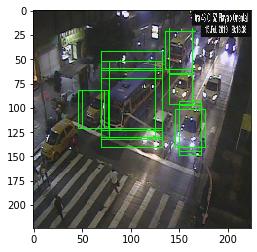

In [109]:
img = utils.plot_bb(tensor[0].numpy(), pos.numpy(), (0, 255, 0), 1)
plt.imshow(img)